<h1>Removing Artifacts From Mammograms</h1>

This notebook can be used to segment the artificial artifacts (number plates, orientation demarcation) from the actual breast tissue in mammogram images from the MIAS and DDSM data sets.

Given the thresholding constraint of human input into the process, migrating this code to UI-interface for segmentation has been integrated into the notebook. 

In [1]:
__version__   = '0.1.0'
__status__    = 'Development'
__date__      = '2017-March-21'
__author__    = 'Jay Narhan'

In [2]:
import os
import cv2
import copy
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

from IPython.display import clear_output
import time

---
<h2>Read in Some Images to Work With</h2>

In [3]:
CURR_DIR = os.getcwd()

# Point to the PNGs to be used: 
IMG_DIR = '/root/Docker-Shared/Data_Resized/MIAS/' 

SAVE_DIR = '/root/Docker-Shared/Data_Thresholded/MIAS/'

filenames = [ filename for filename in os.listdir(IMG_DIR) if filename.endswith('.png')]

In [4]:
images = []
os.chdir(IMG_DIR)
for filename in filenames:
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    images.append({'filename': filename, 'image': img})
os.chdir(CURR_DIR)

print "Number of images in memory: {}".format( len(images))

Number of images in memory: 322


---
<h2>Processing Images</h2>

In [5]:
def get_hists(image, b):
    hist, bins = np.histogram(img.flatten(), bins=b, range=[0,255])
    cdf = hist.cumsum()
    cdf_normalized = cdf *hist.max()/ cdf.max()
    
    return [hist, cdf_normalized]

def plot(img, img_hists):
    plt.figure(1)
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    
    plt.subplot(122)
    plt.plot(img_hists[1], color = 'b')
    plt.plot(img_hists[0], color = 'r')
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    
    plt.subplots_adjust(top=0.92, bottom=0.08,
                        left=0.10, right=0.95,
                        hspace=0.25, wspace=0.35)

<h3>Image Enhancement via Equalization</h3>

Equalization attempts to correct for poor contrast in images. It is commonly used in medical imaging problems. The process looks to better distribute intensities of pixel values through the image.

**Contrast Limited Adaptive Histogram Equalization (CLAHE)**

Ordinary histogram equalization and adaptive equalization for mammograms have been noted as overly enhancing noise and sharp regions in such images. CLAHE has been found to be a more effective strategy to use.

In [6]:
clahe_images = []
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for i, data in enumerate(images):
    clahe_images.append( {'filename': data['filename'], 'clahe_img': clahe.apply(data['image'])})

Total number of CLAHE images: 322


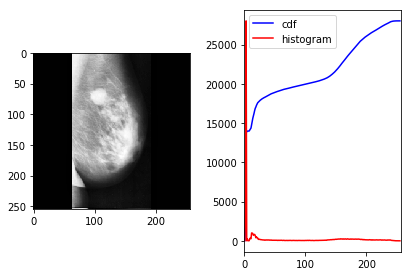

In [7]:
print 'Total number of CLAHE images: {}'.format(np.count_nonzero(clahe_images))
img = clahe_images[321]['clahe_img']
img_hists = get_hists( img, b=256)

plot(img, img_hists)

<h3>Thresholding</h3>

This section aims is the crux of the objective at hand. It aims to segment the breast from the hardware artifacts within the images. Note that as an automated heuristic for thresholding, I used the median pixel value within the mammogram.

There is a need to visual preview the resulting binary image in order to tweak the appropriate threshold value to use. The non-standard structure of mammograms makes it very hard to avoid a human eye in this process.

Tweaking the threshold can be achieved by altering the argument value passed to the parameter "factor'.

In [8]:
# Pass img_list which should be clahe_images stored as list of dict: [ {filename.png, CLAHE_IMG} ]
def threshold(img_list, factor = 1, select_files = []):
    images_t = []
    
    def internal(data):
        thresholded = cv2.threshold(data['clahe_img'],
                                    np.median(data['clahe_img']) * factor, 255,
                                    cv2.THRESH_BINARY)[1]     # just the binary image
            
        _, l, s, _ = cv2.connectedComponentsWithStats(thresholded)
        images_t.append( {'filename': data['filename'],
                          'clahe_img': data['clahe_img'],
                          'thresh_img': thresholded,
                          'factor': factor,
                          'labels':l,                          # labels: contiguous regions in mammogram, labelled
                          'count':s[:, -1]                     # count: count of pixels in each discrete object
                         })
    
    if not select_files:
        print 'Processing all files'
        for i, data in enumerate(img_list):
            internal(data)
            
    else:
        print 'Processing select files {}'.format(select_files)
        for i, data in enumerate(img_list):
            if data['filename'] in select_files:
                internal(data)
                
    return images_t

---

The general idea is to now count the pixels that belong to the breast tissue (in most cases, this will be the largest group of contiguous cells that have pixel value equal to 1 (white) in a binary mage). 

With that information in hand, we can retain the breast object by some multiplication of the original or CLAHE image as follows:

The index to the 'count' component needs to be selected. This index corresponds to the region we wish to retain (breast). In many cases the value of this index will be 1 as a black background will predominate and be indexed by 0. However, sometimes the breast itself may make up most the image, in which case the value to send to the function will be 0. Typically the value used is between 0-1, but not always. Hence a human eye is required.

I use np.argpartition() to get the indices to the two highest counts of discrete objects in the mammograms. This corresponds to regions of interest on which to threshold/mask.

---

In [9]:
def save(fn, img, location=SAVE_DIR):
    print 'Saving: {}'.format(location + fn)
    cv2.imwrite(location + fn, img)
    time.sleep(2)

In [10]:
def mask(image, labels, region):
    labels = copy.deepcopy(labels)  # create a full, unique copy of labels
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            if labels[row, col] != region:
                labels[row, col] = 0  # mask the artifact
            else:
                labels[row, col] = 1  # retain the breast
    return labels

In [11]:
def clean_art(images_thresh):
    revist = []
    for i, data in enumerate(images_thresh):
        fn, c_img, t_img, factor = data['filename'], data['clahe_img'], data['thresh_img'], data['factor']
        print 'Processing File: {}'.format(fn)

        plt.subplot(121)
        plt.imshow(c_img, cmap='gray')
        plt.title('Original')
        plt.subplot(122)
        plt.imshow(t_img, cmap='gray')
        plt.title('Binary Threshold')
        plt.show()
    
        input1 = raw_input("Do you want to save image as-is (Y/N or Q to quit): ").lower()
        if input1 == 'y':
            save(fn, c_img)
        elif (input1 != 'n') & (input1 != 'q'):
            print (".. appending to revist")
            revist.append( {'filename': fn, 'factor': factor, 'thresh_img': t_img})
            time.sleep(2)
        elif input1 == 'q':
            print (".. appending to revist")
            revist.append( {'filename': fn, 'factor': factor, 'thresh_img': t_img})
            time.sleep(2)
            break
        elif input1 == 'n':
            print "Need to threashold"
            input2 = raw_input("Do you want to clear image artifact (Y/N): ").lower()
            if (input2 == 'n') | (input2 != 'y'):
                print (".. appending to revist")
                revist.append( {'filename': fn, 'factor': factor, 'thresh_img': t_img})
                time.sleep(2)
            elif input2 == 'y':
                top_regions = np.argpartition(data['count'], -2)[-2:]
                top_counts = data['count'][top_regions]
                print 'Top region pixel counts: {}'.format(top_counts)
                
                while(True):
                    print 'Associated top regions labels: {}'.format(top_regions)
                    input3 = raw_input("Keep pixels in which region (S to skip): ").lower()
                
                    if input3 == 's':
                        print (".. appending to revist")
                        revist.append( {'filename': fn, 'factor': factor, 'thresh_img': t_img})
                        time.sleep(2)
                        break
                    elif input3.isdigit():
                        input3 = int(input3)
                        if input3 in top_regions:
                            print 'That is a valid region selection!'
                            # mask the region
                            my_mask = mask( t_img, data['labels'], region=input3)
                            image = c_img * my_mask
                            image = np.array(image, dtype = np.uint8)
                            thresh_image = cv2.threshold(image, np.median(image), 255, cv2.THRESH_BINARY)[1]
                        
                            plt.subplot(121)
                            plt.imshow(image, cmap='gray')
                            plt.title('Post Processing')
                            plt.subplot(122)
                            plt.imshow(thresh_image, cmap='gray')
                            plt.title('Post: Binary')
                            plt.show()
                        
                            input4 = raw_input("Save post processed image (Y/N): ").lower()
                            if input4 == 'y':
                                save(fn, image)
                                break
                        else:
                            print 'That is NOT a valid region'
                            print 'Associated top regions labels: {}'.format(top_regions)
                    else:
                        print 'Enter a valid digit please.'
                        print 'Associated top regions labels: {}'.format(top_regions)
        
        clear_output()
    return revist

In [12]:
images_thresh = threshold(clahe_images)
print len(images_thresh)

Processing all files
322


Processing File: mdb007.png


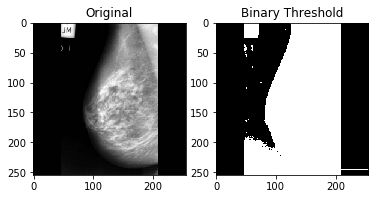

Do you want to save image as-is (Y/N or Q to quit): q
.. appending to revist


In [13]:
remaining = clean_art(images_thresh)

In [14]:
remaining_fn = [item['filename'] for item in remaining]

The threshold levels used generally were 1,2,3,4 and 7 times the median pixel value in the mammogram. If the artifact has not been cleared by the last attempt (i.e. increasing the threshold value to be 7 times the median pixel value), a final attempt was performed used significantly larger values for increasing the threshold levels (up to 20 times).

Note that for some mammograms comprised of mostly fatty tissues (i.e. mammograms that dominated the image space and had large amounts of dark areas - fatty areas, in the image), a factor of 0.5 times the median pixel values was found to be more effective in segmenting the artifacts.

Processing select files ['mdb001.png', 'mdb002.png', 'mdb003.png', 'mdb004.png', 'mdb005.png', 'mdb006.png', 'mdb007.png']
Processing File: mdb001.png


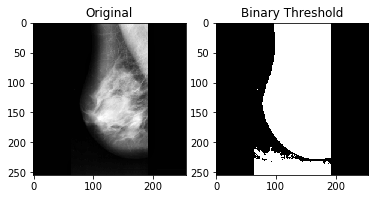

Do you want to save image as-is (Y/N or Q to quit): q
.. appending to revist


In [15]:
images_thresh2 = threshold(clahe_images, factor=2, select_files=remaining_fn)
remaining_fn_2 = clean_art(images_thresh2)